# Programming Exercise 3: Multi-Class Classification and Neural Networks

In [1]:
import numpy as np
import pandas as pd

import scipy.optimize as opt

import os
from scipy.io import loadmat

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Defining necessary functions:

In [2]:
def displayData(X, example_width=None):
    #Displays 2D data stored in X in a nice grid. It returns the figure handle h and the displayed array if requested
    
    plt.close()
    
    #Create a new figure
    plt.figure()
    
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    
    # Gray Image
    plt.set_cmap("gray")    
    
    #Set example_width automatically if not passed in
    if (not example_width) or not 'example_width' in locals():
        example_width = int(np.round(np.sqrt(X.shape[1])))
    
    #Gray image
    
    
    #Compute rows, cols
    m, n = X.shape
    example_height = int((n/example_width))
    
    #Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m/display_rows))
    
    #Between images padding
    pad = 1
    
    #Setup blank display
    display_array = - np.ones([pad + int(display_rows) * (int(example_height) + pad), 
                               pad + int(display_cols) * (int(example_width) + pad)])
    
    #Copy each example into a patch on the display array
    curr_ex = 1
    for j in range(1, int(display_rows)+1):
        for i in range(1, int(display_cols)+1):
            if (curr_ex > m):
                break;
            
            #Copy the patch
            
            #Get the maximum value of the patch
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex = curr_ex + 1
            
        if (curr_ex > m):
            break
    
    #Display Image
    h = plt.imshow(display_array, vmin=-1, vmax=1)
    
    #Do not show axis
    plt.axis('off')
    
    plt.show(block = False)
    
    return h, display_array

In [3]:
def sigmoid(z):
    #g = SIGMOID(z) computes the sigmoid of z.
    
    #Computation
    g = np.zeros(np.shape(z))
    g = 1/(1+np.exp(-z))
    
    return g

In [4]:
def lrCostFunction(theta, X, y, lambda_):
    #COSTFUNCTIONREG Compute cost and gradient for logistic regression with regularization
    
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    #J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    J = np.sum(np.dot((-y.T),np.log(h))-np.dot((1-y).T,np.log(1-h)))/m + (lambda_t / (2 * m)) * np.sum(np.square(temp))
    
    #grad = (1 / m) * (h - y).dot(X) 
    #grad = grad + (lambda_ / m) * temp
    error = h - y
    grad = (np.dot(X.T, error) + lambda_t*temp)/m 
    
    return J, grad.ravel()

In [5]:
def oneVsAll(X, y, num_labels, lambda_):
    #Function trains num_labels logistic regression classifiers and returns each of these classifiers in a matrix all_theta, where the i-th row of all_theta corresponds to the classifier for label i
    
    #Some useful variables
    m, n = X.shape
    
    #You need to return the following variables correctly
    all_theta = np.zeros((num_labels, n + 1)) #all_theta shape = (10, 401) each row consists of 401 theta values for each label
    
    #Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = opt.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y.flatten() == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c] = res.x
        
    return all_theta

In [6]:
def predictOneVsAll(all_theta, X):
    '''
    p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where the i-th row is a trained logistic 
    regression theta vector for the i-th class. You should set p to a vector of values from 1..K 
    (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    for 4 examples) 
    '''
    
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    
    #Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)
    
    return p

In [7]:
def predict(Theta1, Theta2, X):
    #Predict the label of an input given a traine neural network
    
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    
    #Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    #You need to return the following variables correctly
    p = np.zeros((X.shape[0], 1))
    
    #Calculating for hidden layer a2 with parameters Theta1 and a1, where a1 contains bias unit and X
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = sigmoid(a1.dot(Theta1.T))
    
    #Calculating the output layer a3 (h) with parameters Theta2 and a2, where a2 contains bias unit and a2
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    
    #Prediction
    p = np.argmax(a3, axis = 1)
    
    return p

### 1. Multi-class Classification

<p>For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classiﬁcation task.</p>

<p>In the ﬁrst part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classiﬁcation.</p>

### 1.1 Dataset

<p>You are given a data set in X.csv and y.csv that contains 5000 training examples of handwritten digits. There are 5000 training examples in the dataset, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a ﬂoating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.</p>

<p>The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.</p>

In [8]:
data = loadmat(os.path.join('ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
y[y == 10] = 0

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (5000, 400)
Shape of y: (5000,)


In [9]:
#Setup the parameters you will use for this part of the exercise
input_layer_size  = 400  #20x20 Input Images of Digits
num_labels = 10  

m, n = X.shape

### 1.2 Visualize the data

<p>You will begin by visualizing a subset of the training set. In this part, the code randomly selects selects 100 rows from X and passes those rows to the displayData() function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the displayData function, and you are encouraged to examine the code to see how it works.

Visualizing data....


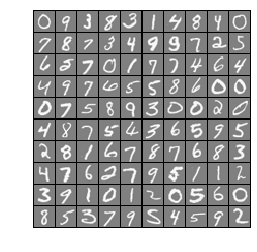

(<matplotlib.image.AxesImage at 0x15773e476a0>,
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        ...,
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]))

In [10]:
print('Visualizing data....')

#Randomly select 100 data points to display
#rand_indices = np.random.permutation(m)
#sel = X[rand_indices[0:100], :]
rand_indices = np.random.choice(m, 100)
sel = X[rand_indices, :]

displayData(sel)

### 1.3 Vectorized Logistic Regression

<p>You will be using multiple one-vs-all logistic regression models to build a multi-class classiﬁer. Since there are 10 classes, you will need to train 10 separate logistic regression classiﬁers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.</p>

### 1.3.3 Vectorizing regularized cost function

<p>After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is deﬁned as
$$J(θ) = \frac{1}{m} \sum_{i=1}^m [y^ilog(h_\theta(x^i)) - (1-y^i)log(1-h_\theta(x^i))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta^2_j$$.</p>
<p>Note that you should not be regularizing $\theta_0$ which is used for the bias term.</p>
<p>Correspondingly, the partial derivative of regularized logistic regression cost for \theta_j is deﬁned as</p>
$$\frac{\partial J(θ)}{\partial θ_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^i))-y^i)x^i_j for j = 0$$
$$\frac{\partial J(θ)}{\partial θ_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^i))-y^i)x^i_j + \frac{\lambda}{m} \theta_j for j \geq 1$$ 

$$X = \begin{bmatrix} (x^1)^T \\ (x^2)^T \\ ... \\ (x^m)^T \end{bmatrix}  and  \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ ... \\ \theta_n \end{bmatrix}$$

<p>Then, by computing the matrix product Xθ, we have</p>
    
$$X \theta = \begin{bmatrix} (x^1)^T\theta \\ (x^2)^T\theta \\ ... \\ (x^m)^T\theta \end{bmatrix} = \begin{bmatrix} \theta^T(x^1) \\ \theta^T(x^2) \\ ... \\ \theta^T(x^m) \end{bmatrix}$$

<p>In the last equality, we used the fact that $a^Tb$ = $b^Ta$ if a and b are vectors. This allows us to compute the products $θ^Tx^i$ for all our examples i in one line of code.</p>

<p>Your job is to write the regularized cost function lrCostFunction(). Your implementation should use the strategy we presented above to calculate $θ^Tx^i$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of lrCostFunction() should not contain any loops. (Hint: You might want to use the element-wise multiplication operation (.*) and the sum operation sum when writing this function)</p>

In [11]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [12]:
#Test case for lrCostFunction
print('Testing lrCostFunction() with regularization')

J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost: ', J)
print('Expected cost: 2.534819')
print('Gradients: ')
print(grad)
print('Expected gradients: 0.146561\n -0.548558\n 0.724722\n 1.398003')

Testing lrCostFunction() with regularization
Cost:  2.534819396109744
Expected cost: 2.534819
Gradients: 
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients: 0.146561
 -0.548558
 0.724722
 1.398003


### 1.4 One-vs-all Classification

<p>In this part of the exercise, you will implement one-vs-all classiﬁcation by training multiple regularized logistic regression classiﬁers, one for each of the K classes in our dataset shown above. In the handwritten digits dataset, K = 10, but your code should work for any value of K.</p>

<p>You should now complete the code in oneVsAll() to train one classiﬁer for each class. In particular, your code should return all the classiﬁer parameters in a matrix $\Theta ∈ R^{K×(N+1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from 1 to K, training each classiﬁer independently.</p>

<p>Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit “0” to the label 10 (to avoid confusions with indexing).</p>

<p>When training the classiﬁer for class k ∈{1,...,K}, you will want a m-dimensional vector of labels y, where $y_j$ ∈ 0,1 indicates whether the j-th training instance belongs to class k ($y_j$ = 1), or if it belongs to a different class ($y_j$ = 0). You may ﬁnd logical arrays helpful for this task.</p>

In [13]:
print('Training One-vs-All Logistic Regression...')
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

Training One-vs-All Logistic Regression...


In [14]:
all_theta[0:5,:1]

array([[-4.63074827],
       [-1.89495995],
       [-3.01996926],
       [-4.43083417],
       [-1.84835333]])

### 1.4.1 One-vs-all Prediction

<p>After training your one-vs-all classiﬁer, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classiﬁers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classiﬁer outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.</p>

<p>You should now complete the code in predictOneVsAll() to use the one-vs-all classiﬁer to make predictions.</p>

<p>Once you are done, call your predictOneVsAll() function using the learned value of $\Theta$. You should see that the training set accuracy is about 93.3% (i.e., it classiﬁes 93.3% of the examples in the training set correctly).

In [15]:
pred = predictOneVsAll(all_theta, X)

In [16]:
#print('Training set accuracy: ', np.mean(pred == y)*100)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 93.30%


### 2. Neural Networks

<p>In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classiﬁer.</p>

<p>In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.</p>

### 2.1 Model representation

<p>Our neural network is shown below. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.</p>

<p>You have been provided with a set of network parameters ($\Theta^1$, $\Theta^2$) already trained by us. These are stored in ex3weights.mat and will be loaded into Theta1 and Theta2 The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).</p>

<img src = "nn model.png"/>

In [17]:
#Setup the parameters you will use for this exercise
input_layer_size = 400 #20 X 20 input images of digits
hidden_layer_size = 25 #25 hidden units
num_labels = 10 #10 labels, from 1 to 10 (0 mapped to label 10)

In [18]:
data = loadmat(os.path.join('ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
y[y == 10] = 0

m, n = X.shape

Visualizing data....


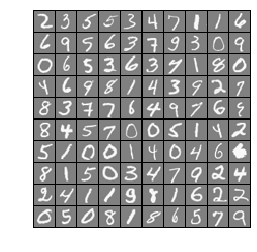

(<matplotlib.image.AxesImage at 0x15773eedeb8>,
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        ...,
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]))

In [19]:
print('Visualizing data....')

#Randomly select 100 data points to display
#rand_indices = np.random.permutation(m)
#sel = X[rand_indices[0:100], :]
rand_indices = np.random.choice(m, 100)
sel = X[rand_indices, :]

displayData(sel)

In [20]:
#Loading Parameters
print('Loading saved neural network parameters...')

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

Loading saved neural network parameters...


### 2.2 Feedforward Propagation and Prediction

<p>Now you will implement feedforward propagation for the neural network. You will need to complete the code in predict.m to return the neural network’s prediction.</p>

<p>You should implement the feedforward computation that computes $h_\theta(x^i)$ for every example i and returns the associated predictions. Similar to the one-vs-all classiﬁcation strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$.</p>

<p>Once you are done, call your predict function using the loaded set of parameters for Theta1 and Theta2. You should see that the accuracy is about 97.5%. After that, an interactive sequence will launch displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image. To stop the image sequence, press Ctrl-C.</p>

<b>Implementation Note</b>:
<p>The matrix X contains the examples in rows. When you complete the code in predict(), you will need to add the column of 1’s to the matrix. The matrices Theta1 and Theta2 contain the parameters for each unit in rows. Speciﬁcally, the ﬁrst row of Theta1 corresponds to the ﬁrst hidden unit in the second layer. When you compute $z^2 = \Theta^1*a^1$, be sure that you index (and if necessary, transpose) X correctly so that you get $a^l$ as a column vector.</p>

In [21]:
pred = predict(Theta1, Theta2, X)

In [22]:
print('Training set accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training set accuracy: 97.52%


To give you an idea of the network's output, you can also run through the examples one at a time to see what it is predicting.

Displaying Image


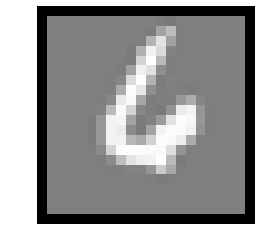

Neural Network Prediction: 6 (digit 6)
Paused - press enter to continue, q to exit:
Displaying Image


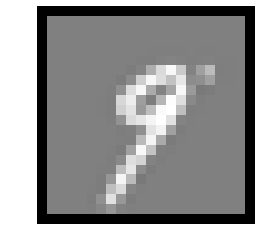

Neural Network Prediction: 9 (digit 9)
Paused - press enter to continue, q to exit:
Displaying Image


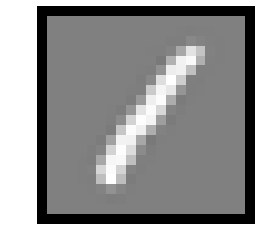

Neural Network Prediction: 1 (digit 1)
Paused - press enter to continue, q to exit:q


In [23]:
#Randomly permute examples
rp = np.random.permutation(m)

for i in range(1, m+1):
    #Display
    print('Displaying Image')
    displayData(X[rp[i], :])
    
    pred = predict(Theta1, Theta2, X[rp[i], :])
    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred)[0]))
    
    #Pause with quit option
    s = input('Paused - press enter to continue, q to exit:')
    if s == 'q':
        break